## Importing ##
All of the required imports are here. All packages are installed as part of anaconda. 

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from string import ascii_lowercase

# Generated data

There are ways to calculate theoretical HDX data, but it can't be applied to this type of experiment easily, nor is it particularly useful to do so here! 

In [5]:
data, labels_true = make_blobs(
    n_samples=300,
    n_features=3,
    centers=9,
    cluster_std=3,
    random_state=1, #for reproducibility
    center_box=[-50,50] #constrain the blob centers within this box
)

data = pd.DataFrame(data, columns=["apo", "eq", "noneq"])

In the case of a real dataset, this data would have already been corrected for a theoretical maximum exchange and combined across several timepoints. The index column would be the residue numbers/sequences of the peptides. This alone is not enough to be used for any kind of prediction, as HDX is influenced by the 3D structure and local environment of the peptide. Whether or not there is rationale for such predictions is why we're doing these experiments in the first place! 

In [6]:
data["noneq_apo"] = data["noneq"] - data["apo"] #difference between noneq and apo
data["noneq_eq"] = data["noneq"] - data["eq"] #difference between noneq and eq
data.head()

,apo,eq,noneq,noneq_apo,noneq_eq
0,-5.860194,22.665155,-48.723225,-42.863031,-71.388380
1,-31.398552,-28.408160,27.825345,59.223898,56.233506
2,-8.630061,28.158536,-48.646000,-40.015939,-76.804536
3,-26.903748,-7.650555,-11.411999,15.491748,-3.761444
4,42.628901,-20.329579,19.853179,-22.775722,40.182758


In [7]:
X = data[["noneq_apo", "noneq_eq"]]
X.head()

,noneq_apo,noneq_eq
0,-42.863031,-71.388380
1,59.223898,56.233506
2,-40.015939,-76.804536
3,15.491748,-3.761444
4,-22.775722,40.182758


I like to have the differences in the original dataset and on their own as X, as I will be manipulating X later on! For example, if I wanted to compare the plots below to the original data:

<AxesSubplot: xlabel='noneq_apo', ylabel='noneq_eq'>

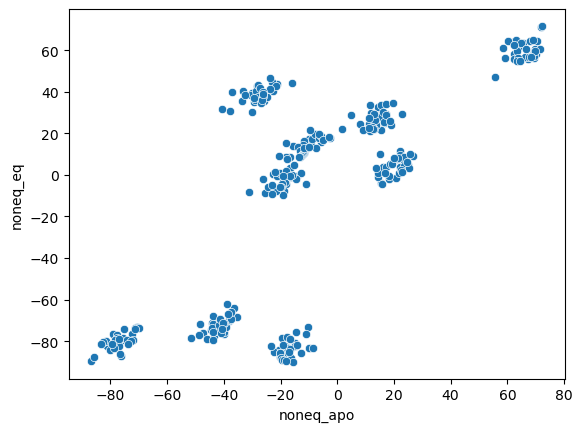

In [8]:
sns.scatterplot(data,x="noneq_apo", y="noneq_eq")

# Scaling
Here our analysis is comparing difference in deuteration between the nonequilibrium experiment and either apo or equilibrium experiments. A real dataset have very different ranges for each peptide (due to peptide length, sequence, and other factors influencing exchange). To account for this, the data needs to be normalised. As there can either be a positive or negative difference the scale should be -1 (biggest decrease) and 1 (biggest increase).

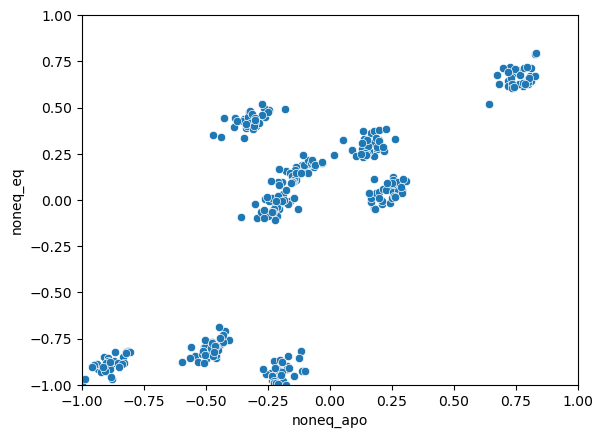

In [9]:
scaler = MaxAbsScaler() #takes maximum value and divides rest of data. Setting it this way allows it to be easily changed if needed

X_scaled_raw=scaler.fit_transform(X)
X=pd.DataFrame(X_scaled_raw, columns=["noneq_apo", "noneq_eq"])
fig=sns.scatterplot(X, x="noneq_apo", y="noneq_eq")
fig.set_xlim(-1,1)
fig.set_ylim(-1,1)
plt.show()

# K means Clustering

Kmeans is a non-hierarchical clustering algorithm that randomly seeds k clusters, assigns points to the nearest centroid, then re-calculates until the centroids are fixed. For this generated dataset we know how many clusters were created, but building the tools to find optimal k is still useful!

Inertia, aka the SSE (sum of the squared Euclidean distances of each point to its closest centroid) or WCSS (within cluster sum of squares) is a measure of error and can be used to assess how appropriately the clusters have been assigned. Luckily, sklearn calculates this!

c:\Users\dpi202\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\dpi202\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


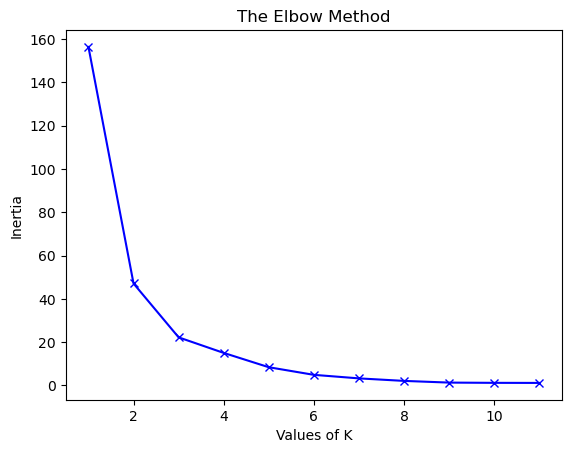

In [10]:
inertias=[]
K=range(1,12)

for k in K:
    kmeanmodel=KMeans(n_clusters=k, random_state=1).fit(X)
    kmeanmodel.fit(X)
    inertias.append(kmeanmodel.inertia_)

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

This is called an "Elbow Plot". In theory, the optimum K is where the "elbow" for the curve is, ie the point that increasing k does not give a meaningful reduction in WCSS. There isn't an obvious point that the inertia clearly starts decreasing linearly. Fortunately, there is another method and plot that can find optimum k: silhouette plots

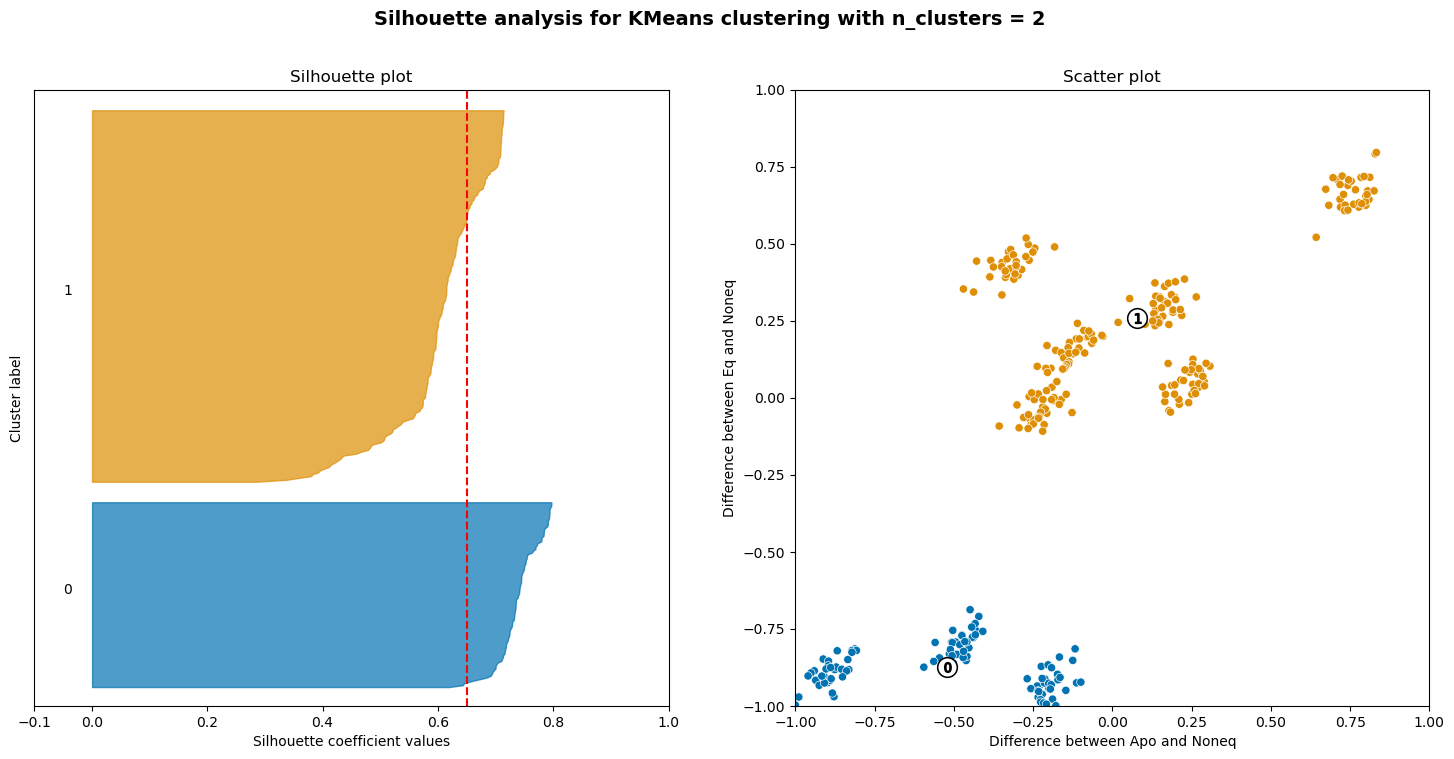

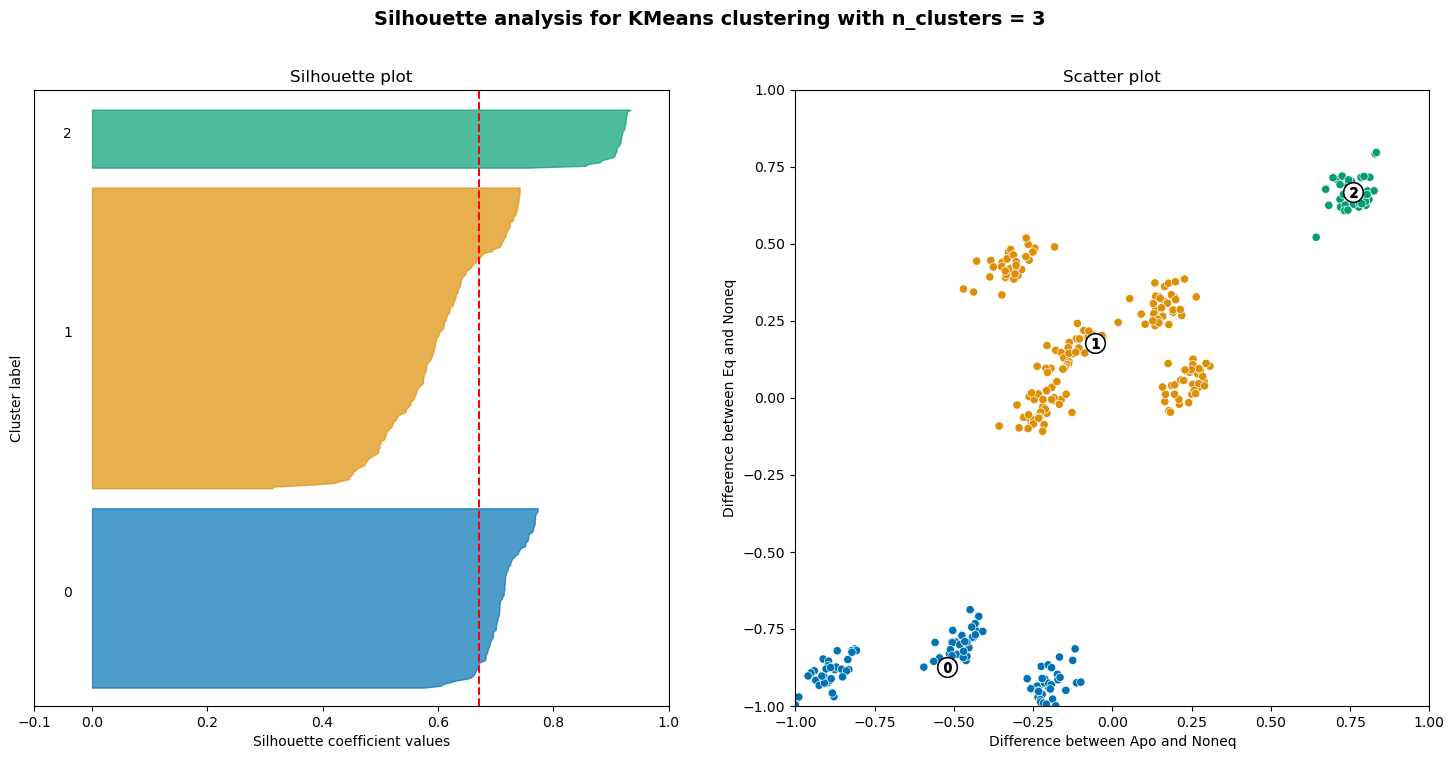

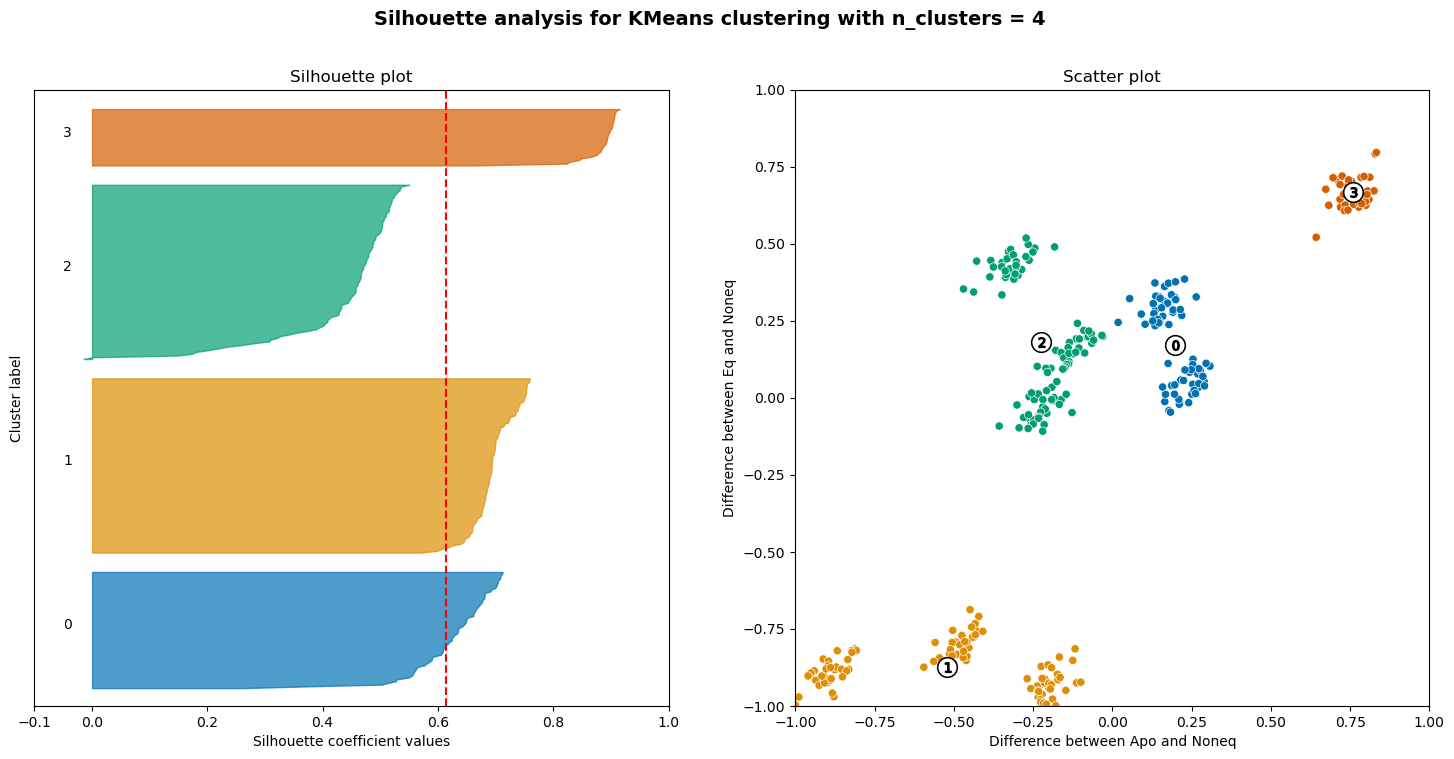

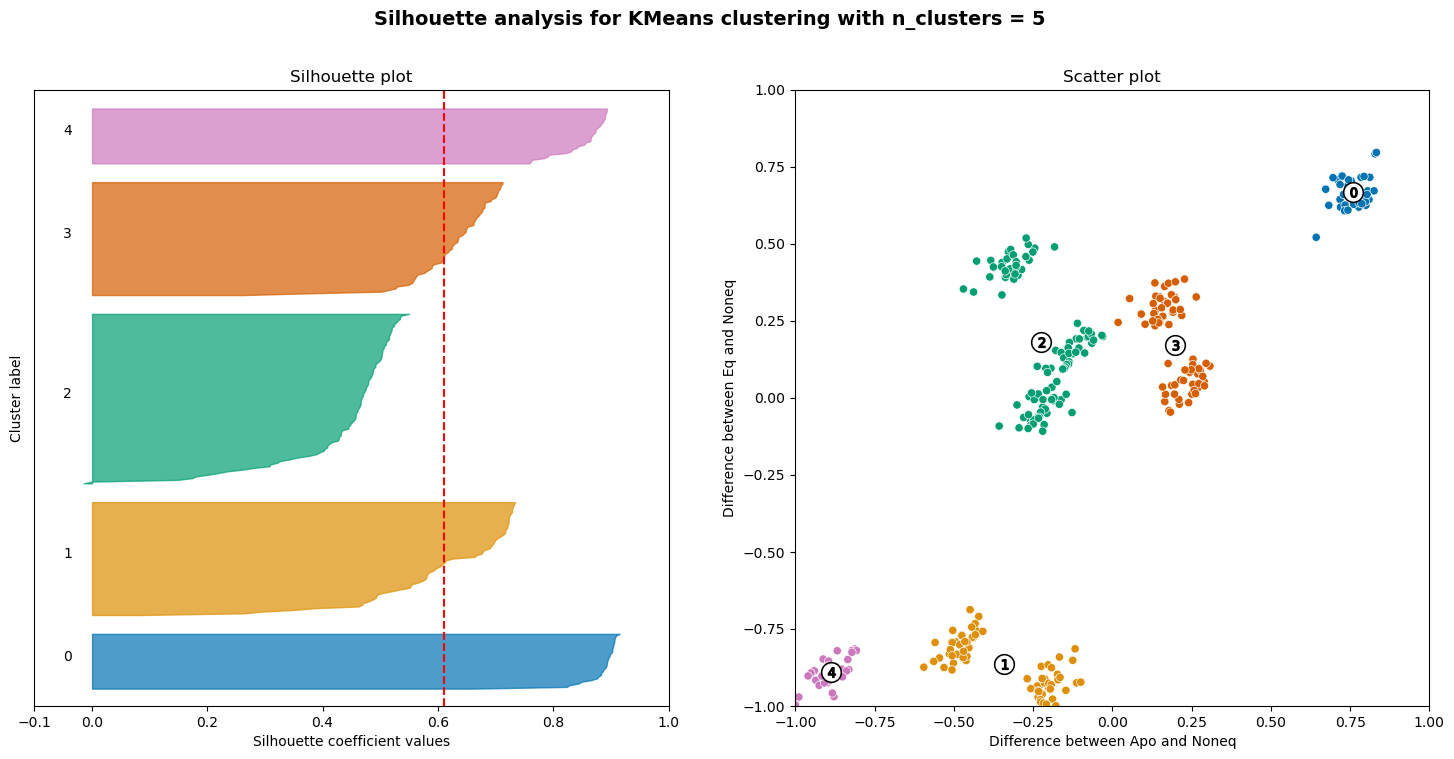

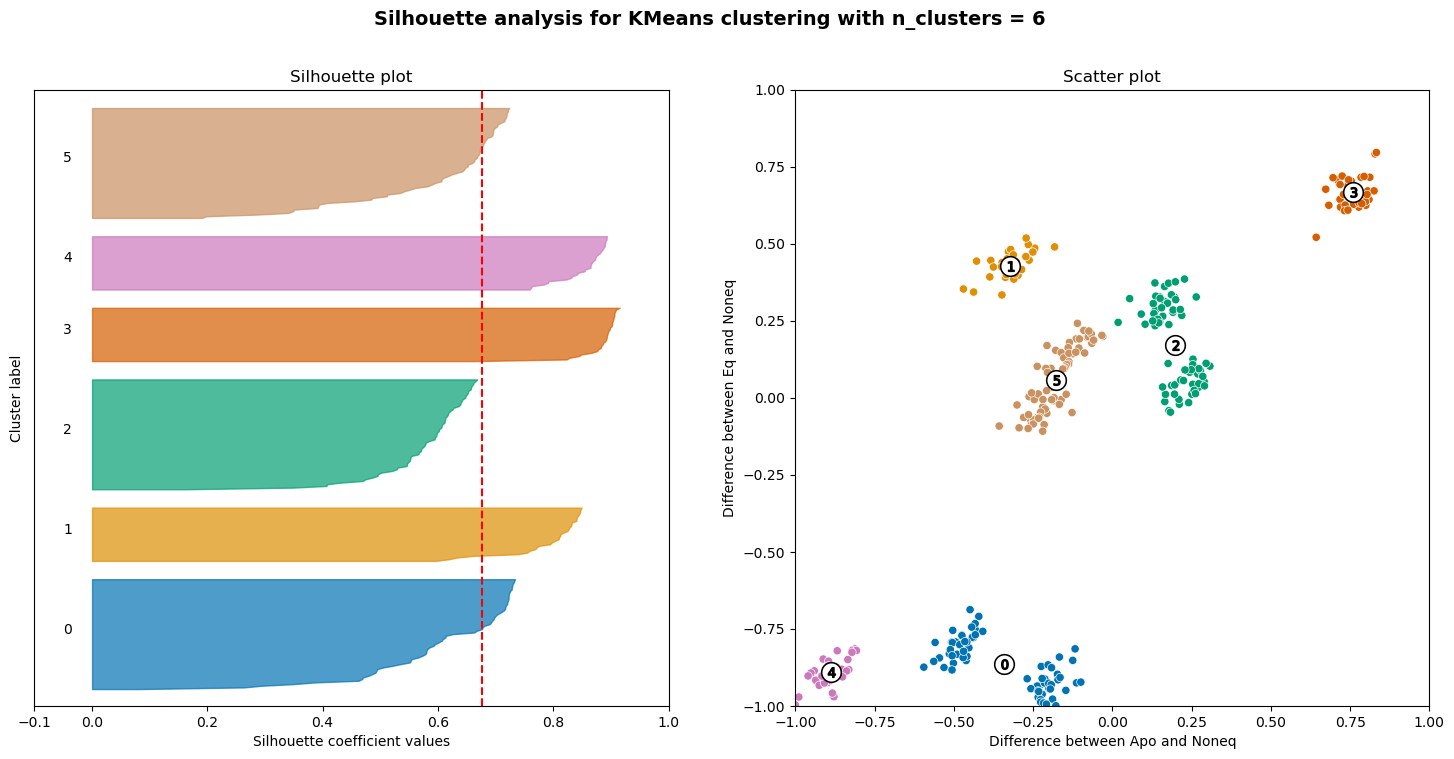

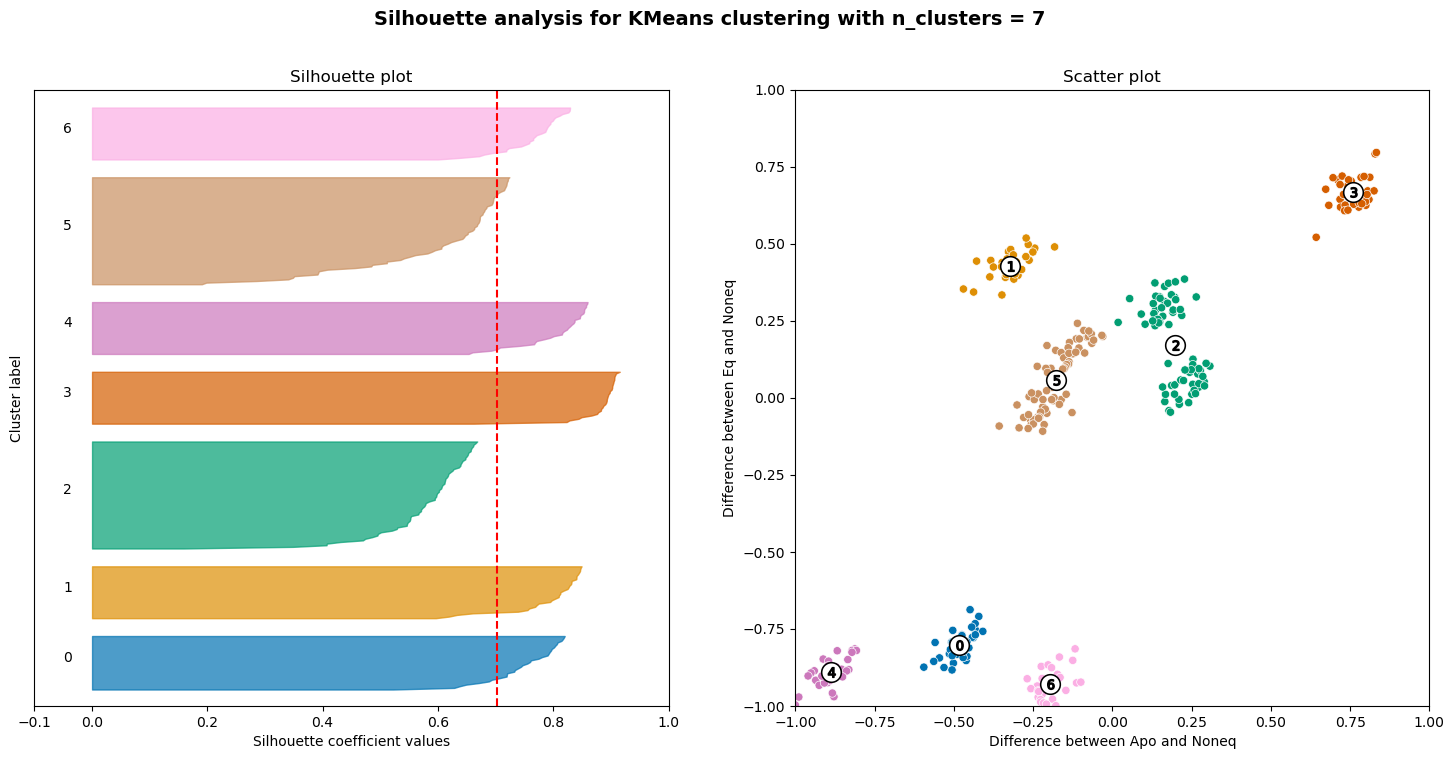

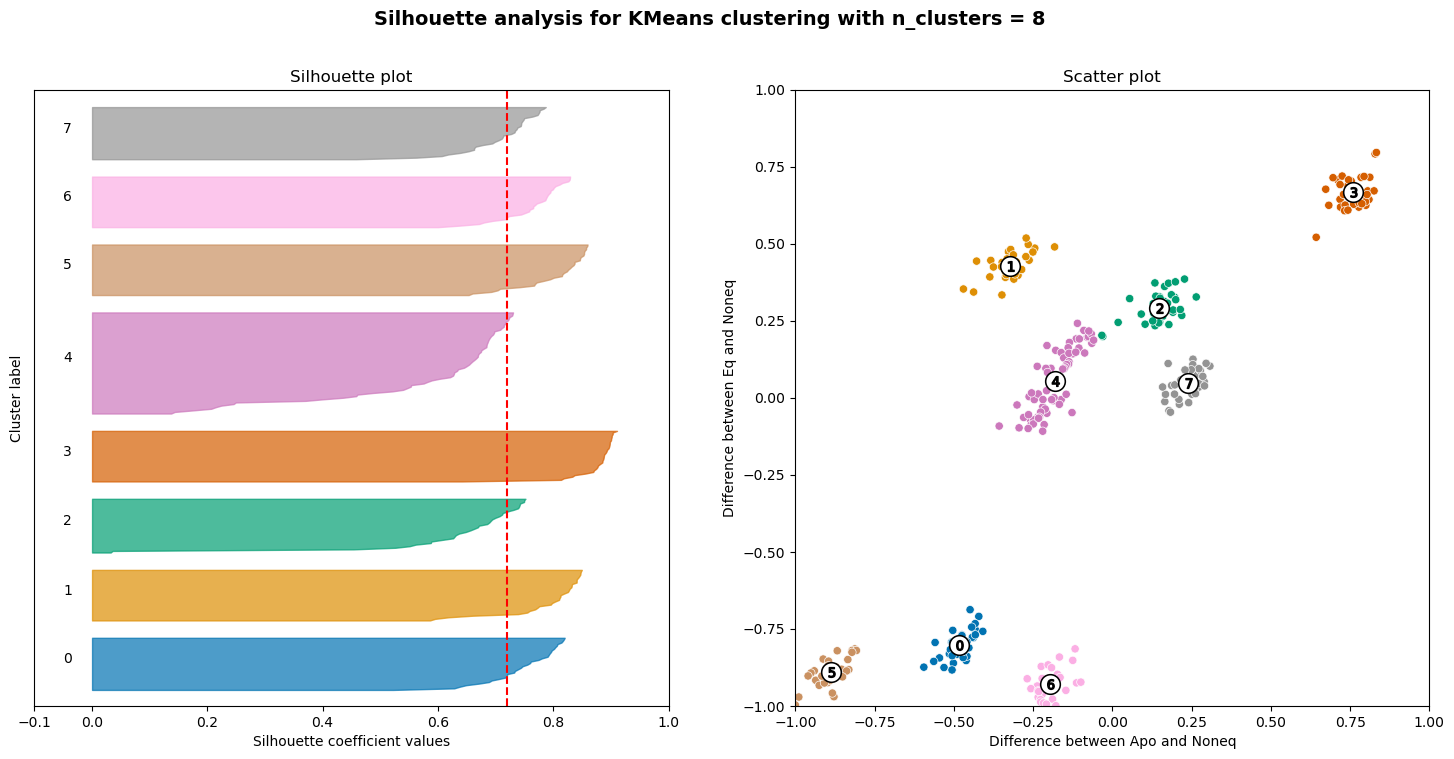

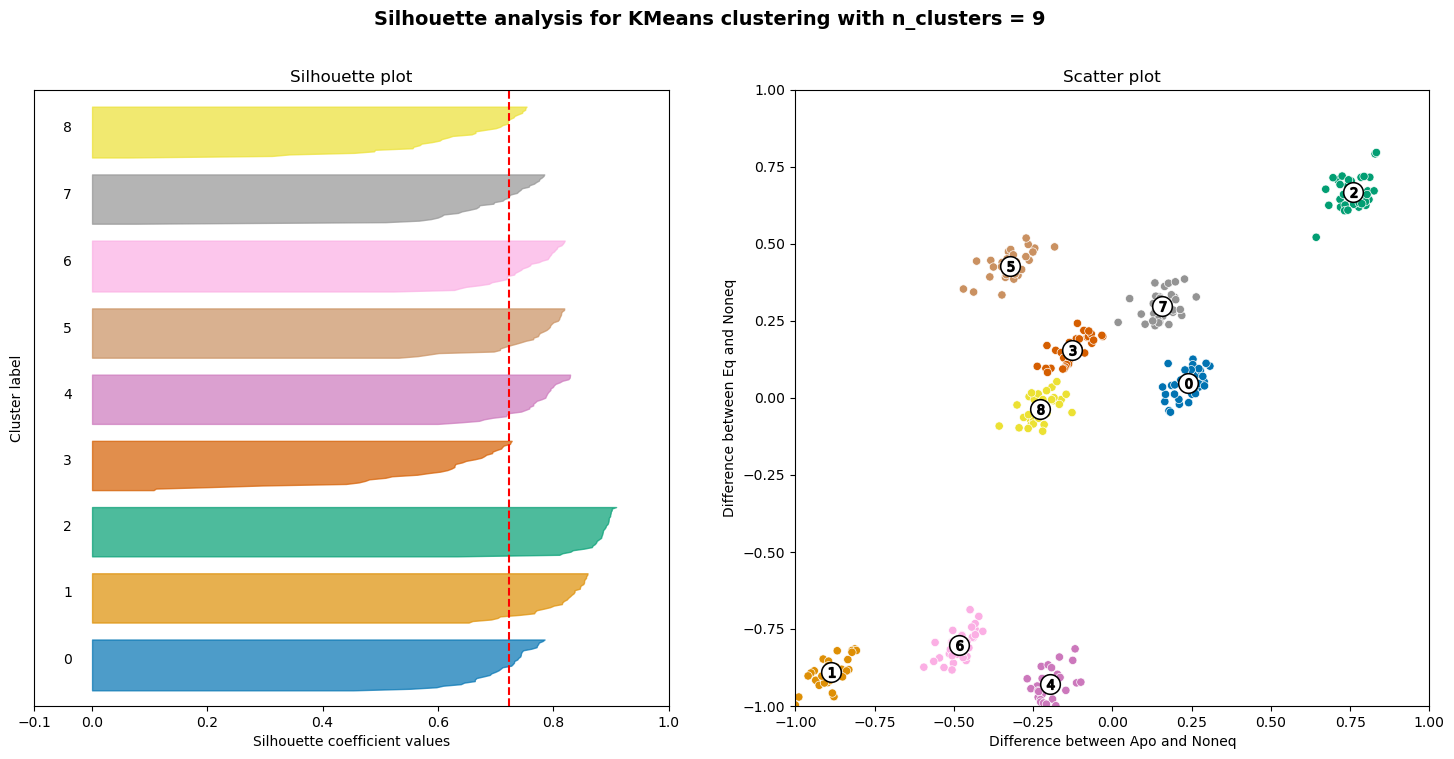

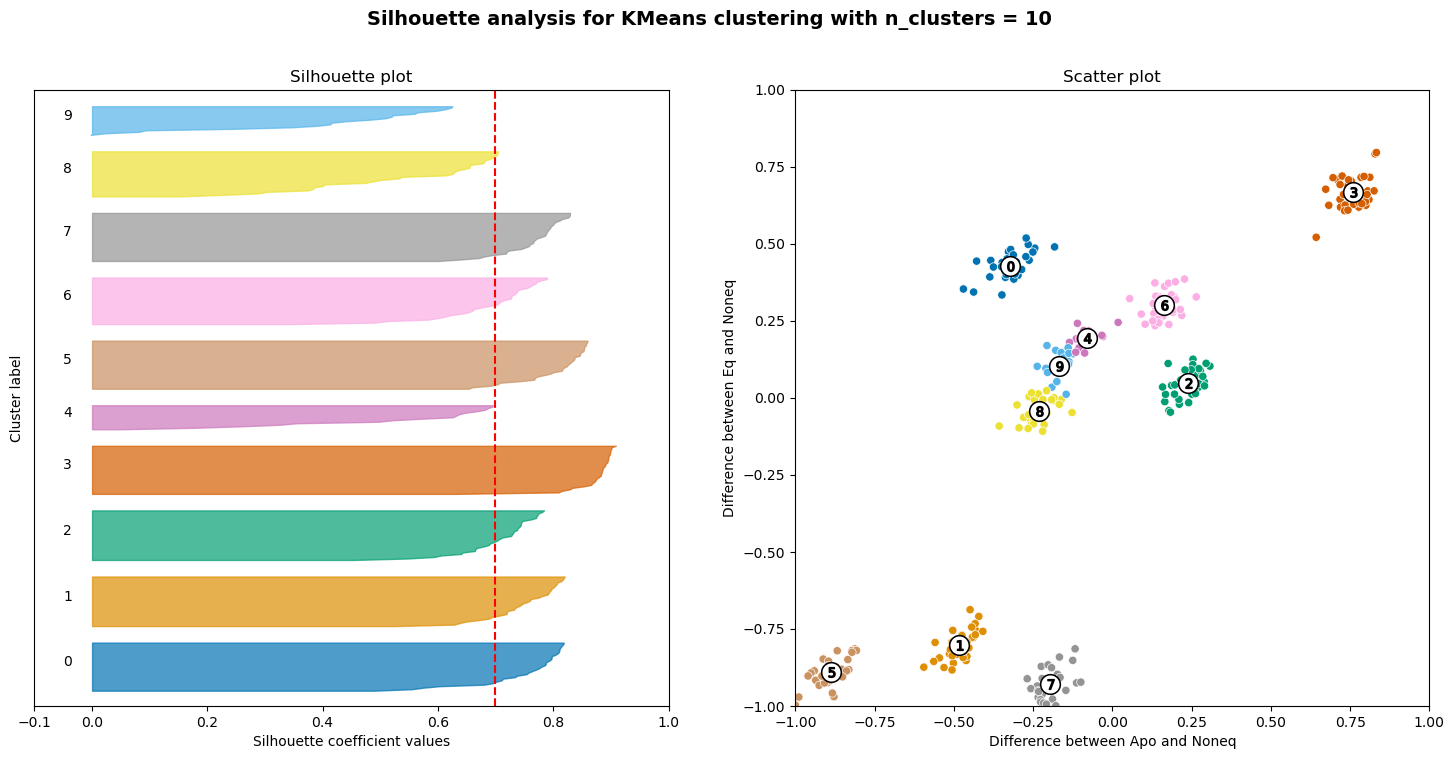

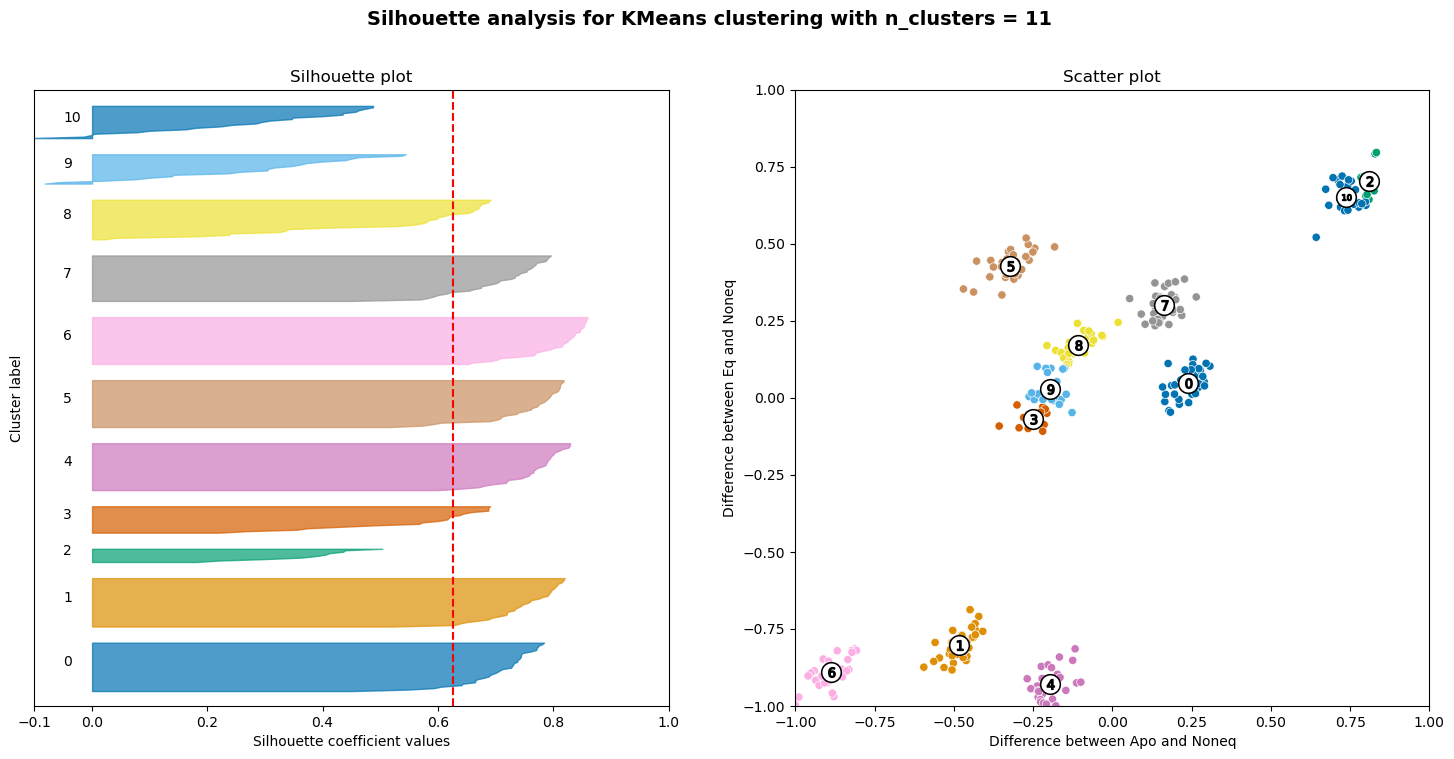

In [11]:
scores={} #for calling the maximum later

for k in range(2,11): #this range can be anything above k=2, especially if the number of plots output is annoying

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,8)

    #create the color palette dictionary for later
    palette=sns.color_palette("colorblind", k) #creating a palette with k colors helps when using continuous palettes
    color_map=dict(zip(range(0,k), palette))

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10]) # this creates space between each silhouette
    
    kmeanmodel=KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeanmodel.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels) #average across all values
    scores[k]=silhouette_avg #add to scores dict to find maximum score later
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #create the silhouette by filling between these x and y values
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper), #y values
            0,
            ith_cluster_silhouette_values, #x values
            facecolor=color_map[i],
            edgecolor=color_map[i],
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    ax2.set_xlim(-1,1)
    ax2.set_ylim(-1,1)

    #this is to stop the previous iteration's clusters being added to the next kmeans analysis...
    X2 = X[["noneq_apo", "noneq_eq"]]
    X2["clusters"] = cluster_labels 
    
    #this time can use seaborn scatterplot. the inputs are nicer!
    sns.scatterplot(
        X2, 
        x="noneq_apo",
        y="noneq_eq",
        hue="clusters",
        palette="colorblind",
        legend=False
        )

    # Labeling the clusters
    centers = kmeanmodel.cluster_centers_

    # Draw white circles at cluster centers
    sns.scatterplot(
        x=centers[:, 0],
        y=centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
        legend=False
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
   #using matplotlib scatter as I can't get the indexing of c to work with seaborn,  and the placement of adding it as text is wrong 

    ax2.set_title("Scatter plot")
    ax2.set_xlabel("Difference between noneq and apo")
    ax2.set_ylabel("Difference between noneq and eq")
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering with n_clusters = %d" % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

A good silhouette plot has evenly sized clusters, all of which at least touch the red average line. k=9 is the only plot that satisfies this; 8 does meet the red avg line, but cluster 4 is bigger than the others. Luckily the scores that we saved in a dictionary means we can find the maximum score for a more quantitative measure:

In [12]:
optimumK=max(scores, key=scores.get) #get k value with maximum silhouette score
print(f'Optimum number of clusters: {optimumK}')

#now re-do the kmeans cluster with that optimum k value
kmeans = KMeans(n_clusters = optimumK).fit(X)
X["cluster"] = kmeans.fit_predict(X)
centers = pd.DataFrame(kmeans.cluster_centers_, columns =["noneq_apo", "noneq_eq"]) #coordinates for each centroid

Optimum number of clusters: 9


Obviously we know that it's 9 as that's what I input when generating the data, but for a real dataset this is useful, and it's a good sanity check!

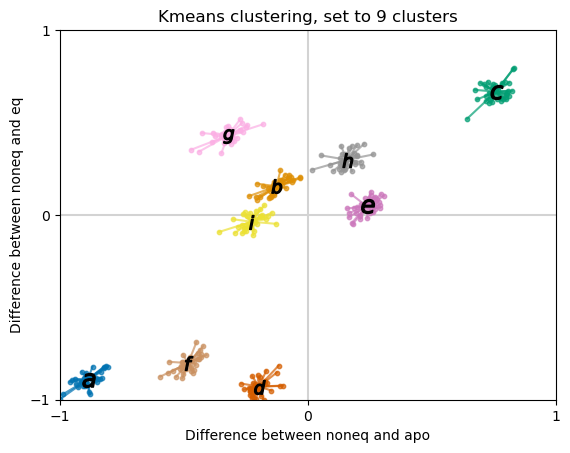

In [18]:
D = X.to_numpy() #so the iterations below will work
label = kmeans.labels_

#fixing axes, plotting origin
ax = plt.gca()
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_xlabel("Difference between noneq and apo")
ax.set_ylabel("Difference between noneq and eq")

plt.axhline(0, color='lightgrey', zorder=0)
plt.axvline(0, color='lightgrey', zorder=0)

colors = plt.cycler("color", sns.color_palette("colorblind", optimumK)) 

# allows matplotlib to cycle through plot colours
# I would use seaborn and 'hue=label' for this, but again plotting the text isn't going well, nor is some of the indexing.
# We can still use pretty seaborn colours though :)

for k, col in zip(range(0,9), colors):
    class_members = label == k #basically creating a mask for each cluster
    centroids=centers.iloc[k]

    plt.scatter( #plot individual data points
        D[class_members, 0],
        D[class_members, 1],
        color=col["color"],
        marker="o",
        s=10,
        alpha=0.7
    ) 

    plt.scatter( #plot centroid as letter
    centroids[0],
    centroids[1],
    s=100,
    color="black",
    marker=r"$ {} $".format(ascii_lowercase[k]),
    zorder=10
    ) 

    for x in D[class_members]: #joins each point to the centroid of their cluster
        plt.plot(
            [centroids[0], x[0]],
            [centroids[1], x[1]],
            color=col["color"],
            zorder=0,
            alpha=0.7
        ) 
        #Here the points are quite tightly clustered, but this is useful for real data that can be spread out unevenly

plt.title("Kmeans clustering, set to 9 clusters")
plt.show()


Here I've labelled the clusters with letters not numbers to make sure it's distinct from the 9 theoretical clusters.

Silhouette plot code adapted from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)